# 細胞画像から細胞状態を直接予測する

今までは、細胞の大きさなどを観測した後に、芽の大きさで細胞周期を分けることを考えていましたが、ここでは、画像から直接細胞状態を推定する予測器を作成します。手間のかかる特徴量の抽出を無くせるという利点がある一方で、どの特徴が重要で分類できたのかは分かりにくくなるので、目的によって、適切に使い分けてください。

深層学習のサンプルとして、数字のMNIST、画像のImageNetなどの定形データに対する解析方法は、いずれの深層学習フレームワークでもドキュメントに書かれていますが、データ形式が少し変化したりすると、とたんにドキュメントが少なくなる現状のため、この講義では、生命科学ではよくあるだろうシチュエーションのデータ形式を考えつつ、サンプルを用意します。難解だとおもったら、PyTorchのチュートリアルなどを見て、再度このドキュメント・プログラムを見てもらえればと思います。

## ライブラリの読み込み

2節同様に、利用するライブラリ一群を読み込みます。

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.utils.data as data
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import copy
import argparse
import time
import numpy as np
import pandas as pd

## データの読み込み

特徴量から読み込んだ事例では、学習開始前に全てのデータを読み込み、学習時には、そこからバッチ毎にデータを読み込んでいました。画像の場合も同様ですが、ここでは、大規模データに対応できる工夫を導入します。

画像や動画の場合には、枚数が多くなるとメモリに乗らない分量の大規模なデータになることがあります。このような場合には、学習前に全てのデータを読み込むことはできません。そこで、学習前にはファイル名（あるいは、ファイル名を知るために必要な値）だけを読み込み、バッチ毎に、バッチ内にあるサンプルの画像や動画を読み込みます。これにより、バッチ対象となるデータが読み込みさえすれば、学習を進めることができるので、全データ分のメモリが用意できなくても学習が可能です。

さらに、このバッチごとの読み込みには複数の利点があります。

* 深層学習では、高速化のためCPUではなくGPUを利用した計算が行われますが、GPUの欠点として、メモリが少ないことが挙げられます。たとえば、現在よく使われるNVIDIA社のGTX1080で8GB、サーバ用途で利用されるNVIDIA社のTESLA V100で16GB〜32GBと、CPUから利用できるメモリに比べると少々少なくなっています。バッチごとのデータ読み込みが可能になることで、メモリ量が限られた環境でも、効率良い学習が可能になります。
* データの擬似的な拡張(水増し：Augmentation)との相性が良いです。例えば、画像解析を考えた場合に、上下左右の反転をしたり、回転をしても、同一のクラスとして認識して欲しい場合が多くあります（カメラを傾けても、ネコはネコなので）。この場合、画像を適当な角度で回転して、学習しても構わないことになります。予め、様々な角度の画像を用意しておくことも、一つの作戦ですが、ただでさえ枚数が多い画像が更に多くなって、ハードディスク容量の圧迫に繋がる可能性があります。そこで、バッチ毎に画像を読み込む際に、乱数を発生させて、適当な角度に回転したり、上下左右を入れ替えたりすることで、あらたなデータを予め用意することなく、水増しが可能になります。

以下のプログラムでは、make_dataset 関数が、特徴量同様に学習前に呼び出される関数です。この時、特徴量ではなく、画像のファイル名を作成し、酵母画像のファイル名とクラスの対応表を作成しています。
画像は、PhotoID列をX, CellID列をYとすると、```data/images/C_yor202w_0_0_X_Y.png``` に入っています。よって、各細胞に対して、このファイル名と、クラスを割り当てます。クラスが"no", "small","medium","large" をそれぞれ別の次元とした4次元で表すのは、前節の事例と同じです。

In [77]:
def make_dataset(dir):
    images = []
    labels = []
    dataset = pd.read_csv(os.path.join(dir, "yeast_his3.csv"))
    for _, row in dataset[["Cgroup","PhotoID", "CellID"]].iterrows():
        filename = "C_yor202w_0_0_%d_%d" % (row["PhotoID"], row["CellID"])
        image_path = os.path.join(dir, "images", filename + ".png")
        y = [0, 0, 0, 0]
        if row["Cgroup"] == "no":
            y = [1, 0, 0, 0]
        elif row["Cgroup"] == "small":
            y = [0, 1, 0, 0]
        elif row["Cgroup"] == "medium":
            y = [0, 0, 1, 0]
        elif row["Cgroup"] == "large":
            y = [0, 0, 0, 1]
        images.append(image_path)
        labels.append(np.array(y))
    return images, labels


前節同様に、訓練データ、バリデーションデータ、テストデータで分割を実施しましょう。

In [78]:
# 全体を、training, valid, testに分ける。ここでは、3:1:1 に分割。
# training + valid が、機械学習の training data 相当。
datadir = "../data"
X, y = make_dataset(datadir)
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size = 0.25
)

前節では、各バッチでは、DatasetFolder内の値を読み出していました。ここでも同様ですが、前節では、値を読み出すときには、PyTorchのTensor型に変換をしていたところを

* 指定したパスの画像情報を読み出す (pil_loader関数)
* 必要に応じて、画像の大きさを変換する (後述)。もしくは、水増しを行う。
* 色の正規化を行う（後述）

などの操作を追加します。

In [79]:
class DatasetFolder(data.Dataset):
    def __init__(self, X, y, loader, transform=None, target_transform=None):
        self.loader = loader
        self.samples = X
        self.targets = y
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        path = self.samples[index]
        target = self.targets[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.samples)


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

画像読み込み時の、画像サイズの変換や色の補正を実施します。

前節の事例では、特徴量も、クラスも、また、訓練、バリデーション、テストのいずれでも、一律に変換をしていました。ここでも訓練、バリデーション、テストのいずれでも基本的に一律の変換を実施しますが、特徴量は画像に変わっているため、画像特有の変換が実施できるように、それぞれ独立して定義を行います。

In [80]:
# 画像の輝度値を補正するための関数を設定。
# ResNet等のPre-trained model 学習時に利用されていた値
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# 画像の幅と高さ
WIDTH = 224
HEIGHT = 224

# training (validation, testも同様）時に、画像に対して変換を加える場合は、
# ここに記述する。ResizeやFlipなど。
# 参照：https://pytorch.org/docs/stable/torchvision/transforms.html
# 変換のあと、pytorchで扱うために、Tensor型に変換してあげる必要あり。
# normalize(上記の関数)は、Tensor型に変換したあと、実施
data_transforms = {
    # training data用。必要ならaugmentation(Flipや切り出し)を行う
    # 今は、特段の加工は行わない。
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        #normalize　# 後で画像を表示するために、一旦コメントアウトしておく。
    ]),
    # validation用。通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # test用。こちらもFlip等は実施しない
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

# クラスの変換。今回はPytorchのテンソルに変換するだけ
# 他に必要な変換がある場合には、画像同様に記載可能。
class ToTensorOfTarget(object):
    def __call__(self, target):
        return torch.from_numpy(target)

target_transforms = transforms.Compose([
        ToTensorOfTarget()
])

# 画像とクラスの読み込み用の関数を定義
image_datasets = {
    'train':YeastImageDataset(X_train, y_train,
                              data_transforms['train'],
                              target_transforms),
    'val':YeastImageDataset(X_val, y_val,
                             data_transforms['val'],
                             target_transforms),
    'test': YeastImageDataset(X_test, y_test,
                             data_transforms['test'],
                             target_transforms)
}


以上の準備が正しくできていることを確認するため、image_datasetsを呼び出して、帰ってくる画像を表示してみます。

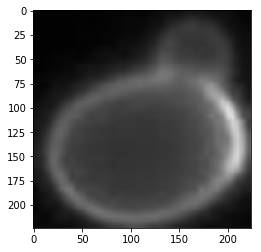

In [81]:
sample_id = 3
sample_img, _ = image_datasets['train'][sample_id]
sample_img = transforms.ToPILImage('RGB')(sample_img) # Tensor を画像に変換（もとに戻す）
plt.figure()
plt.imshow(sample_img)
plt.show()

画像を表示しやすいように、標準化をコメントアウトしていたので、戻します。

In [84]:
data_transforms = {
    # training data用。必要ならaugmentation(Flipや切り出し)を行う
    # 今は、特段の加工は行わない。
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # validation用。通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # test用。こちらもFlip等は実施しない
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

バッチごとの読み込み用の設定。前節と同様。

In [94]:
# バッチサイズ分のデータを読み込む。
# training はデータをシャッフルし、読み込み始める画像をランダムにする。
# 他はシャッフルの必要なし。
batch_size=64
workers=0
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

## ネットワークアーキテクチャ

画像解析で広く使われるResNetなどの固定したアーキテクチャもありますが、ここでは汎用性に重きをおいて、シンプルなCNNの記載からスタートします。

ここでは、
```入力画像 -> Conv2D -> ReLU -> MaxPooling -> Conv2D -> ReLU -> MaxPooling -> Linear -> ReLU -> Linear ```
という形のネットワークを組みます。

ToDO: ConvolutionやPoolingが何であるかの説明。図が必要？

In [105]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=(1,1))
        self.fc1 = nn.Linear(16 * 56 * 56, 120) # channel_num * x * y
        self.fc2 = nn.Linear(120, 4)

    def forward(self, x):
        # ** convolution layers **
        # 224 x 224 -> 112 x 112 
        x = self.pool(F.relu(self.conv1(x)))
        # 112 x 112 -> 56 x 56
        x = self.pool(F.relu(self.conv2(x)))
        # convert to 1-dim
        x = x.view(-1, 16 * 56 * 56) # channel_num * x * y
        # ** classification layers **
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv1とconv2が、2次元（＝画像）のコンボリューションを実施する層になっています。poolはプーリング層、fc1とfc2は全結合層です。
* nn.Conv2d(3, 6, 5, padding=(2,2)): 3チャンネル(=RGB)の入力を、6チャネルに拡張。
* nn.MaxPool2d(2, 2): 2x2のマス目でMaxPooling を実施。
* ... 
と、利用する層の種類のの定義が行われています。

上記の関数で定義した層を、どのように組み合わせるのか表したものが、forward 関数です。こちらでは、活性化関数としてReLUを利用して、
* x = self.pool(F.relu(self.conv1(x))): 入力画像 -> Conv2D (conv1) -> ReLU -> MaxPooling (pool)
* x = self.pool(F.relu(self.conv2(x))): -> Conv2D (conv2) -> ReLU -> MaxPooling (pool)
* x.view(-1, 16 * 56 * 56): 平滑化
* x = F.relu(self.fc1(x)): -> Linear -> ReLU
* x = self.fc2(x): 最後のclassification層

という形で、ネットワークの構成を順番に記載しています。

前節同様に、作成したネットワークは、指定するデバイスに転送します。

In [106]:
device_name = "cpu"
device = torch.device(device_name)
model = Net()
model = model.to(device_name)

## 学習ステップの定義

学習ステップの詳細を定義します。現在までに、ネットワークアーキテクチャの変更と、バッチごとのデータ取得の変更（画像を取得するように）を行いましたが、この学習しテップは、前節と全く同じ関数です。

In [98]:
def print_test_accuracy(model, criterion, optimizer, phase):
    running_loss = 0.0
    running_corrects = 0
    model.train(False)

    for inputs, labels in dataloaders[phase]:
        labels = labels.float()
        inputs = inputs.to(device)
        labels = labels.to(device)

        #optimizer.zero_grad()

        # 訓練のときだけ履歴を保持する
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, classnums = torch.max(labels, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, classnums)

        # 統計情報
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == classnums)

    # サンプル数で割って平均を求める
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    print('On Test:\tLoss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


def train_model(model, criterion, optimizer, scheduler, outpath, num_epochs=25):
    since = time.time()
    # 途中経過でモデル保存するための初期化
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 時間計測用
    end = time.time()

    print(model)
    print()

    for epoch in range(num_epochs):
        print('Epoch:{}/{}'.format(epoch, num_epochs - 1), end="")

        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                labels = labels.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 訓練のときだけ履歴を保持する
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, classnums = torch.max(labels, 1)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classnums)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 統計情報
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classnums)

            # サンプル数で割って平均を求める
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\t{} Loss: {:.4f} Acc: {:.4f} Time: {:.4f}'.format(phase, epoch_loss, epoch_acc, time.time()-end), end="")

            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            end = time.time()

        print()

    time_elapsed = time.time() - since
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

## 深層学習の実行

実行も、前節と同様です。つまり、深層学習を用いて画像の分類をする場合には、一見長く見えるプログラムの部分は変更の必要は無く、モデルやデータの読み込みを変更すればよいとわかります。

各エポック、１０秒以上かかりますので、表示が出なくても焦らずに待ってください。

In [108]:
epochs = 10
batch_size = 64
lr = 0.01
momentum = 0.9
outdir = "."

# Loss関数の定義。
# Regression なので、CrossEntropy から、MSELossに変更
criterion = nn.CrossEntropyLoss()
# optimizer の定義
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# 10 エポックごとに学習率を0.1倍する
# 値は、ここでは固定してしまっているが、本来は可変。
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
# 実際の学習を実施する
# 結果出力用ファイルのprefix
outpath = os.path.join(outdir, "cnn_b%d_lr%f_m%f_e%d" % (batch_size, lr, momentum, epochs))
model = train_model(model, criterion, optimizer, exp_lr_scheduler, outpath, num_epochs=epochs)
# 学習が終わったら、結果を保存する。
torch.save(model.state_dict(), 'model.pkl')
# テストデータでの精度を求める
print_test_accuracy(model, criterion, optimizer, 'test')


Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
)

Epoch:0/9	train Loss: 0.7253 Acc: 0.7611 Time: 6.6630	val Loss: 1.3202 Acc: 0.5263 Time: 1.2392
Epoch:1/9	train Loss: 0.5291 Acc: 0.7611 Time: 5.9355	val Loss: 1.2957 Acc: 0.5000 Time: 1.1271
Epoch:2/9	train Loss: 0.5969 Acc: 0.7389 Time: 5.7072	val Loss: 1.1912 Acc: 0.5000 Time: 1.1212
Epoch:3/9	train Loss: 0.4591 Acc: 0.8761 Time: 5.8885	val Loss: 1.4049 Acc: 0.5132 Time: 1.2014
Epoch:4/9	train Loss: 0.3345 Acc: 0.8761 Time: 5.6536	val Loss: 1.7908 Acc: 0.5132 Time: 1.2147
Epoch:5/9	train Loss: 0.2838 Acc: 0.8982 Time: 5.8146	val Loss: 2.0115 Acc: 0.5526 Time: 1.2042
Epoch:6/9	train Loss: 0.2724 Acc: 0.8805 Time: 5.9603	va